<a href="https://colab.research.google.com/github/bilalzaidi88/Credit-Card-Fraud-Detection/blob/master/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import time
import random
import datetime

import numpy as np 
import pandas as pd
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import model_selection

In [0]:
# load data
# datapath = '/kaggle/input'
trainid_df = pd.read_csv('train_identity.csv')
traintx_df = pd.read_csv('train_transaction.csv')
testid_df = pd.read_csv('test_identity.csv')
testtx_df = pd.read_csv('test_transaction.csv')
submit_df = pd.read_csv('sample_submission.csv')

# TODO: train_identity = pd.read_csv(f'{folder_path}train_identity.csv', dtype={'TransactionAmt': str})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81704 entries, 0 to 81703
Columns: 435 entries, TransactionID_x to DeviceInfo
dtypes: float64(399), int64(5), object(31)
memory usage: 271.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80639 entries, 0 to 80638
Columns: 434 entries, TransactionID_x to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 267.0+ MB
None


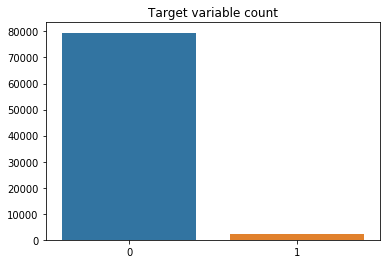

In [3]:
# merge dfs
train_df = traintx_df.merge(trainid_df, how='left', left_index=True, right_index=True)
test_df = testtx_df.merge(testid_df, how='left', left_index=True, right_index=True)

x = train_df['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count')

# unload raw csvs from the memory
del trainid_df
del traintx_df
del testid_df
del testtx_df

print(train_df.info())
print(test_df.info())

In [0]:
# remove columns with a high proportion of null values
nb_rows = train_df.shape[0]
cols_to_remove = []
for col in train_df.columns:
    if train_df[col].isna().sum()/nb_rows >= .9:
        cols_to_remove.append(col)

train_df.drop(cols_to_remove, axis=1, inplace=True)
test_df.drop(cols_to_remove, axis=1, inplace=True)

In [0]:
cat_cols = [
    'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
    'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27',
    'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35',
    'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 
    'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 
    'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
for col in cat_cols:
    if col in train_df.columns:
        le = preprocessing.LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))

In [0]:
X = train_df.drop(['isFraud', 'TransactionID_x'], axis=1)
y = train_df['isFraud']

test_df.drop(['TransactionID_x'], axis=1, inplace=True)

In [7]:
type(X)

pandas.core.frame.DataFrame

In [0]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer()
X = my_imputer.fit_transform(X)
test_df = my_imputer.transform(test_df)

del train_df

In [9]:
type(X)

numpy.ndarray

In [10]:
# tackling the data imbalance
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X, y = smote.fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [11]:
X.shape

(159020, 420)

In [12]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

folds = model_selection.TimeSeriesSplit(n_splits=5)

aucs = list()
training_start_time = time.time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time.time()
    print('Training on fold {}'.format(fold + 1))
    
    #trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    #val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    trn_data = lgb.Dataset(X[trn_idx], label=y[trn_idx])
    val_data = lgb.Dataset(X[test_idx], label=y[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time.time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time.time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999998	valid_1's auc: 0.893974
Early stopping, best iteration is:
[1231]	training's auc: 1	valid_1's auc: 0.894762
Fold 1 finished in 0:01:09.409698
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999997	valid_1's auc: 0.910833
Early stopping, best iteration is:
[679]	training's auc: 0.999695	valid_1's auc: 0.91138
Fold 2 finished in 0:01:41.412380
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999996	valid_1's auc: 0.966341
Early stopping, best iteration is:
[1359]	training's auc: 1	valid_1's auc: 0.968279
Fold 3 finished in 0:03:56.178322
Training on fold 4
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.98172	valid_1's auc: 1
Fold 4 finished in 0:02:04.684942
Training on fold 5
Training unt

In [0]:
best_iter = clf.best_iteration

In [14]:
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X, y)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.3797454081646243, importance_type='split',
               learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.03454472573214212,
               min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=1, num_leaves=491, objective='binary',
               random_state=47, reg_alpha=0.3899927210061127,
               reg_lambda=0.6485237330340494, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [0]:
submit_df['isFraud'] = clf.predict_proba(test_df)[:, 1]
submit_df.to_csv('Submission_Bilal.csv', index=False)